<a href="https://colab.research.google.com/github/quiquedalfo/Proyecto-DH-CDI61185-Dalfo/blob/main/VentasZapatos_Dalfo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Ventas de zapatos 2023**

Este dataset pertenece a mi trabajo. Se trata de las ventas de zapatos en el año 2023. El objetivo de este proyecto es identificar las familias de zapatos con mayor cantidad de ventas por mes, para identificar la estacionalidad de esa familia, si la hubiere. Luego, identificar la subfamilia dentro de esa familia con mayores ventas y realizar una prediccion de ventas en base a las alturas mas relevantes de esa subfamilia.

In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
url = 'https://raw.githubusercontent.com/quiquedalfo/Proyecto-DH-CDI61185-Dalfo/main/2023.csv'
df = pd.read_csv(url, sep=';')
df.head()

,fnum,fobs,ft101,ffch,fven,fturno,fart,fcolo,ftall,fcant,...,Temp,UFL,Altura Caña,Altura Taco,Altura Punta,Pendiente,Rango,Estacion,Nombre,Color
0,113001499,FECHA: 01/01/23,MDP,1/1/2023,1397,2,388395,38839,5,1,...,VER22,11/11/2021,0,35,30,5,baja,1VERANO,Dustland,Blanco
1,113001500,FECHA: 01/01/23,MDP,1/1/2023,1397,2,388409,38840,9,1,...,VER22,28/10/2021,0,43,31,10,baja,1VERANO,Nearness,Negro
2,113001501,FECHA: 01/01/23,MDP,1/1/2023,1397,2,397085,39708,5,1,...,VER23,16/11/2022,0,98,71,25,alta,1VERANO,Muse,Negro
3,113001502,FECHA: 01/01/23,MDP,1/1/2023,1335,2,378819,37881,9,-1,...,VER21SS,1/11/2020,0,73,8,0,0,1VERANO,Glory,Negro
4,113001502,FECHA: 01/01/23,MDP,1/1/2023,1335,2,388948,38894,8,1,...,VER22,10/1/2022,0,0,3,0,0,1VERANO,Upside,Negro


Preguntas de interes:

*   Que familia de zapatos se venden mas?
*   Identificar top familas de verano y de invierno segun ventas.
*   Segun la altura de caña de la mejor subfamilia dentro de la mejor familia. Que cantidad de ventas se pueden pronoticar al momento de fabricar un nuevo zapato?


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113392 entries, 0 to 113391
Data columns (total 26 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   fnum          113392 non-null  int64 
 1   fobs          113392 non-null  object
 2   ft101         113392 non-null  object
 3   ffch          113392 non-null  object
 4   fven          113392 non-null  object
 5   fturno        113392 non-null  int64 
 6   fart          113392 non-null  int64 
 7   fcolo         113392 non-null  int64 
 8   ftall         113392 non-null  int64 
 9   fcant         113392 non-null  int64 
 10  fprun         113392 non-null  object
 11  fneto         113392 non-null  object
 12  fhora         113392 non-null  object
 13  Familia       113235 non-null  object
 14  Subfamilia    113235 non-null  object
 15  Tunif         113235 non-null  object
 16  Temp          113235 non-null  object
 17  UFL           113392 non-null  object
 18  Altura Caña   113392 non

In [4]:
columns_seleccionadas = ['ffch','fcolo', 'ftall', 'fcant','Altura Taco','Altura Punta','Familia','Subfamilia','Tunif','Altura Caña','Nombre','Color']
df = df.rename(columns={'ffch': 'Fecha', 'articulo': 'Articulo', 'talle': 'Talle','fcant': 'Cantidad'})
df = df.fillna(0)
df.tail()

,fnum,fobs,ft101,Fecha,fven,fturno,fart,fcolo,ftall,Cantidad,...,Temp,UFL,Altura Caña,Altura Taco,Altura Punta,Pendiente,Rango,Estacion,Nombre,Color
113387,143012851,FECHA: 31/12/23,UNI,31/12/2023,1341,2,405685,40568,5,1,...,VER24,7/2/2024,0,85,60,0,0,1VERANO,Kat,Negro
113388,143012852,FECHA: 31/12/23,UNI,31/12/2023,1459,2,403268,40326,8,-1,...,VER24,1/11/2023,0,16,10,0,0,1VERANO,Smooth,Dorado
113389,143012852,FECHA: 31/12/23,UNI,31/12/2023,1459,2,402578,40257,8,1,...,VER24,1/11/2023,0,73,8,0,0,1VERANO,Glory,Nude
113390,144000322,FECHA: 31/12/23,UNI,31/12/2023,1341,2,403146,40314,6,1,...,VER24,1/11/2023,0,83,9,0,0,1VERANO,Nightingale,Dorado
113391,343002124,FECHA: 31/12/23,UNI,31/12/2023,1055,2,372438,37243,8,-1,...,VER21SS,31/5/2024,0,80,30,50,media,1VERANO,Hedy,Negro


In [5]:
for column in df.columns:
  if df[column].dtype == 'object':
    df[column] = df[column].str.upper().str.strip()

In [6]:
print(df['Familia'].unique())

['GOMA BAJA' 'GOMA ALTA' 'SUELA SANDALIA' 'TACO Y PLATAFORMA' 'GOMA MEDIA'
 'CHATAS' 'TEXANAS' 'BASES' 'LOAFERS' 'MOCASINES' 'SNEAKERS' 'G BOTA'
 'BORCEGOS' 'STILETTOS' 'SUELA BOTA' 'G-TACO Y PLATAFORMA' 'BALLERINAS'
 nan 'VINTAGE' '0' 'SUELA BORCEGO' 'MADERAS' 'ZVARIOS' 'SUELA ZAPATO'
 'ESTRIBO']


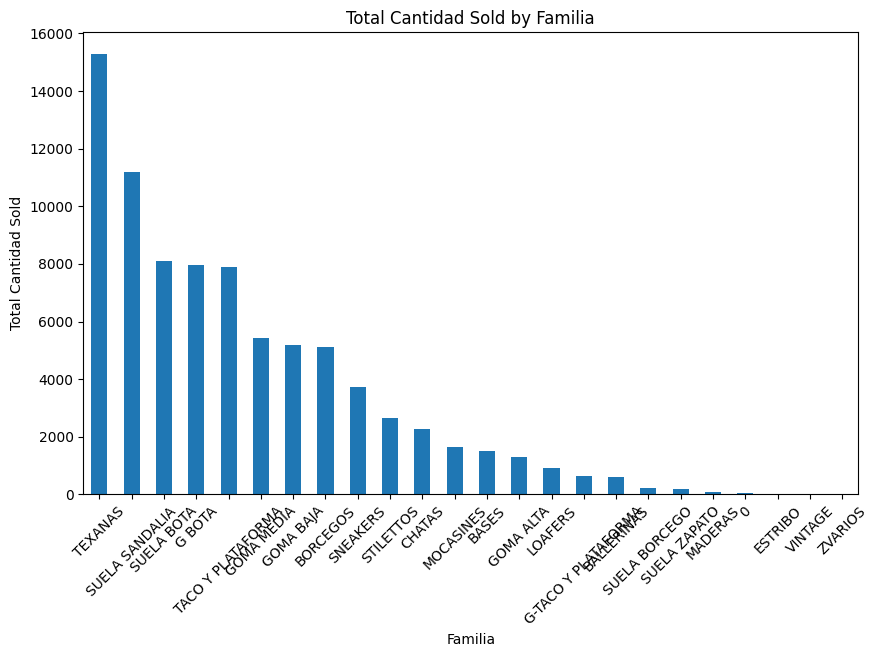

In [7]:
# Calcular total 'Cantidad' por grupo 'Familia'
familia_cantidad = df.groupby('Familia')['Cantidad'].sum().sort_values(ascending=False)

# Create the plot
ax = familia_cantidad.plot(kind='bar', figsize=(10, 6))
plt.title('Total Cantidad Sold by Familia')
plt.xlabel('Familia')
plt.ylabel('Total Cantidad Sold')
plt.xticks(rotation=45)

plt.show()

Cantidad de ventas por familia,utilizado para identificar las familias que mas venden en general.

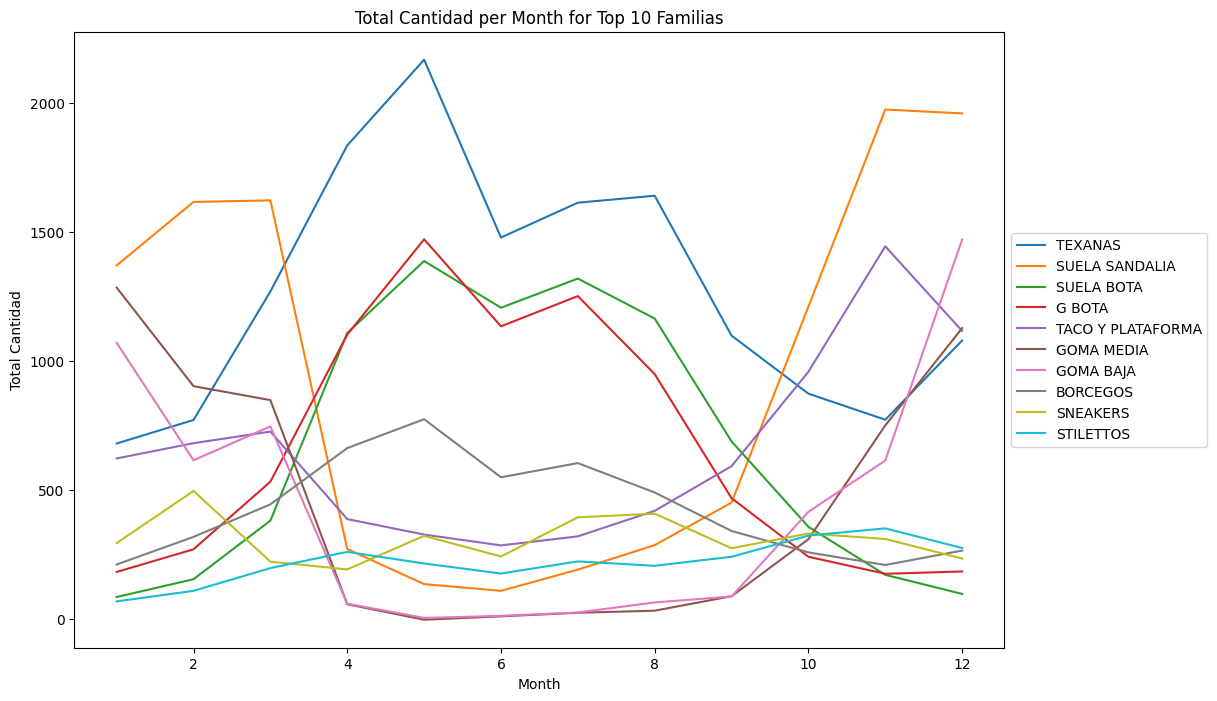

In [9]:
# Calcular total 'Cantidad' por grupo 'Familia' para top 10
familia_cantidad = df.groupby('Familia')['Cantidad'].sum().sort_values(ascending=False).head(10)

# Top 10 'Familia'
top_10_familias = familia_cantidad.index.tolist()

# Filtrar DataFrame para el top 10 'Familia'
df_filtered = df[df['Familia'].isin(top_10_familias)].copy()

# Convertir 'Fecha' a datetime
df_filtered['Fecha'] = pd.to_datetime(df_filtered['Fecha'], format='%d/%m/%Y', errors='coerce')

# Extraer mes de 'Fecha'
df_filtered['Month'] = df_filtered['Fecha'].dt.month

# Agrupar por mes y familia y calcular totales
monthly_sales = df_filtered.groupby(['Month', 'Familia'])['Cantidad'].sum().reset_index()

# Pivot el mes
monthly_sales_pivot = monthly_sales.pivot(index='Month', columns='Familia', values='Cantidad')

# Crear plot de Totales por familia por mes.
plt.figure(figsize=(12, 8))
for familia in top_10_familias:
  plt.plot(monthly_sales_pivot.index, monthly_sales_pivot[familia], label=familia)

plt.xlabel("Month")
plt.ylabel("Total Cantidad")
plt.title("Total Cantidad per Month for Top 10 Familias")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5)) # Move legend outside the plot
plt.show()

Este grafico muestra el top 10 de familias con mas ventas y el total de ventas por mes. Las curvas demuestran que si existen familias de verano y de invierno.

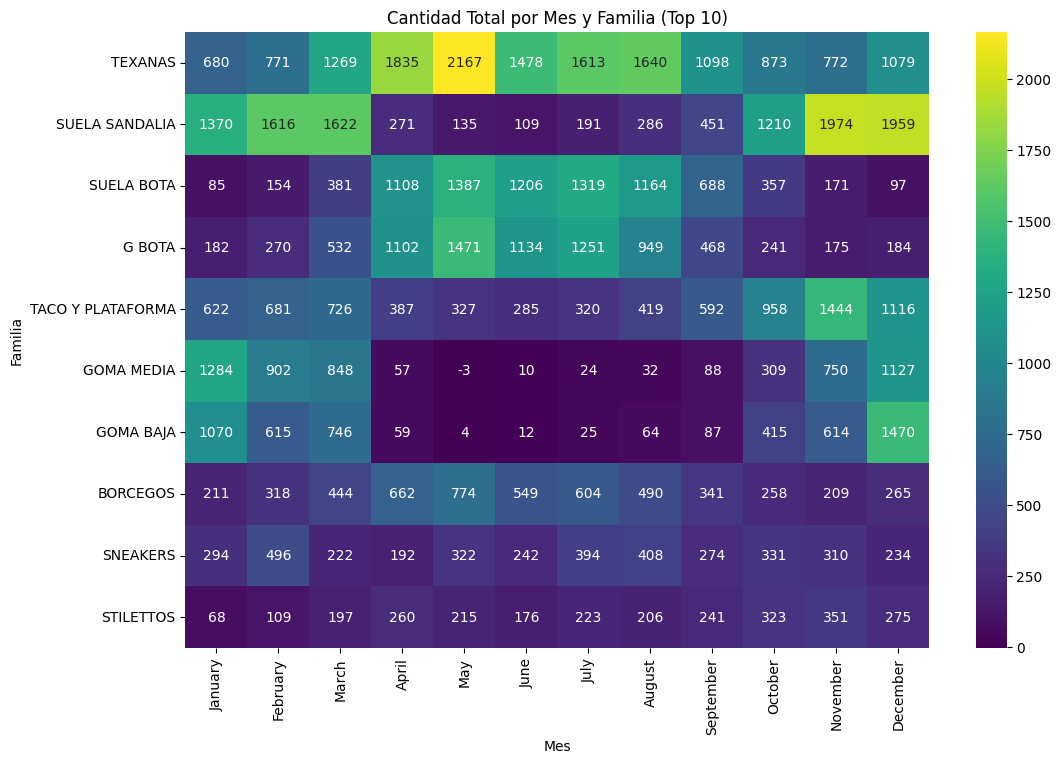

In [20]:
# Convertir 'Fecha' a datetime y extraer el mes
df['Fecha'] = pd.to_datetime(df['Fecha'], format='%d/%m/%Y', errors='coerce')
df['Mes'] = df['Fecha'].dt.month

# Calcular la Cantidad total por mes y Familia
monthly_sales = df.groupby(['Mes', 'Familia'])['Cantidad'].sum().reset_index()

# Obtener las 10 Familias principales
top_10_familias = monthly_sales.groupby('Familia')['Cantidad'].sum().sort_values(ascending=False).head(10).index

# Crear el heatmap
heatmap_data = monthly_sales[monthly_sales['Familia'].isin(top_10_familias)].pivot(index='Familia', columns='Mes', values='Cantidad')
heatmap_data = heatmap_data.reindex(top_10_familias)

# Configurar el heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, cmap='viridis', annot=True, fmt='g', xticklabels=pd.to_datetime(heatmap_data.columns, format='%m').strftime('%B'))
plt.xlabel("Mes")
plt.ylabel("Familia")
plt.title("Cantidad Total por Mes y Familia (Top 10)")
plt.show()

Este heatmap muestra las ventas por mes, confirmando las familias de verano, las de invierno y las que se venden todo el año.

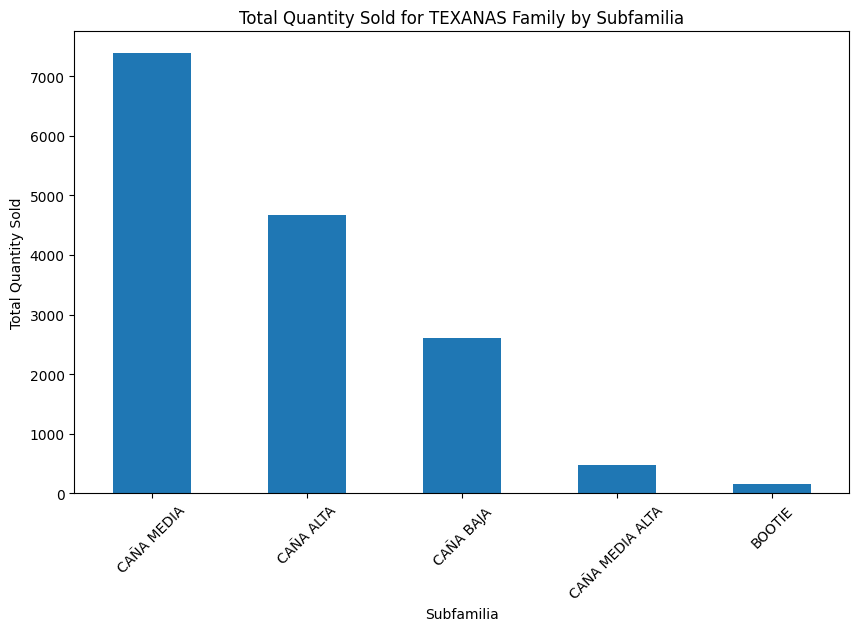

In [21]:
# Filtrar por 'TEXANAS'
texanas_df = df[df['Familia'] == 'TEXANAS']

# Agrupar por subfamilia
color_cantidad = texanas_df.groupby('Subfamilia')['Cantidad'].sum().sort_values(ascending=False)

# Crear grafio de barras
ax = color_cantidad.plot(kind='bar', figsize=(10, 6))
plt.title('Total Quantity Sold for TEXANAS Family by Subfamilia')
plt.xlabel('Subfamilia')
plt.ylabel('Total Quantity Sold')
plt.xticks(rotation=45)

plt.show()

Sabiendo que TEXANAS es la familia que tiene mas ventas dentro de la compañia, se abre por subfamilias para encontrar la que tiene mas ventas, siendo Caña media.

Este heatmap mostraria que combinacion de altura caña y altura taco son las ganadoras a la hora de pensar la siguiente TEXANA - Caña media

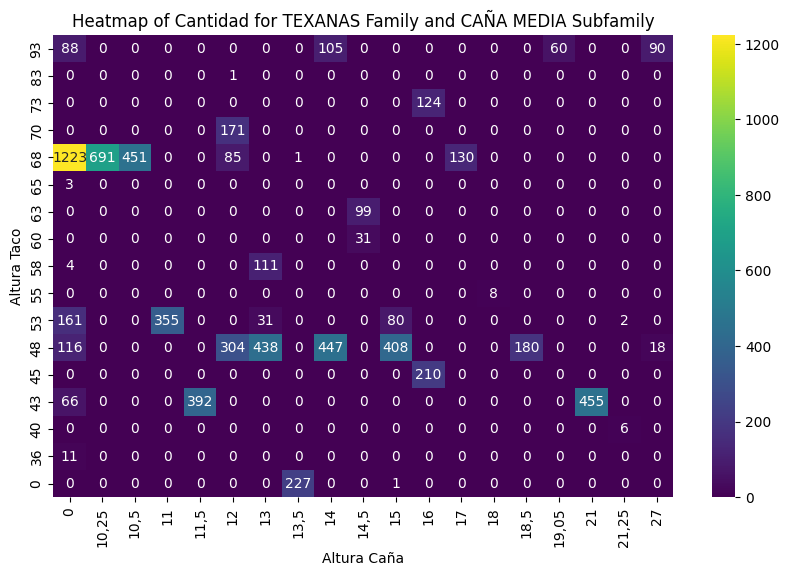

In [22]:
# Filtrar por 'TEXANAS' y 'CAÑA MEDIA'
filtered_df = df[(df['Familia'] == 'TEXANAS') & (df['Subfamilia'] == 'CAÑA MEDIA')]

# Pivotear 'Altura Taco' como index, 'Altura Caña' como columna,
# 'Cantidad' como valores y suma como cantidad
matrix = filtered_df.pivot_table(index='Altura Taco', columns='Altura Caña', values='Cantidad', aggfunc='sum')

# Llenar NA con 0
matrix = matrix.fillna(0)

# Ordenar index
matrix = matrix.sort_index(ascending=False)

# Crear heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(matrix, annot=True, fmt='g', cmap='viridis')
plt.title('Heatmap of Cantidad for TEXANAS Family and CAÑA MEDIA Subfamily')
plt.xlabel('Altura Caña')
plt.ylabel('Altura Taco')
plt.show()

Conclusion: Se confirmo que existe una estacionalidad para grupos de zapatos. Se pueden identificar familias de zapatos de invierno y de verano. Luego, se trabajo para identificar el subgrupo o subfamilia dentro de la familia con mayor cantidad de ventas para luego realizar un analisis de regresion para identificar que probabilidad de ventas tendria un zapato de esa subfamilia que cumpla con las mismas caracteristicas dentro de ese subgrupo (Altura de taco y Altura de caña).


In [77]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

# Filtrar datos para la subfamilia "CAÑA MEDIA" dentro de la familia "TEXANAS"
df_filtered = df[(df['Familia'] == 'TEXANAS') & (df['Subfamilia'] == 'CAÑA MEDIA')].copy()

# Verificar si las columnas son de tipo object (texto) antes de convertir
if df_filtered['Altura Caña'].dtype == 'object':
    df_filtered['Altura Caña'] = df_filtered['Altura Caña'].str.replace(',', '.').astype(float)

# Agrupar por altura de caña y sumar la cantidad
df_grouped = df_filtered.groupby('Altura Caña')['Cantidad'].sum().reset_index()

# Dividir los datos en conjuntos de entrenamiento y prueba (40% para prueba)
X_train, X_test, y_train, y_test = train_test_split(df_grouped[['Altura Caña']], df_grouped['Cantidad'], test_size=0.4, random_state=42)

# Ajustar una regresión lineal
model = LinearRegression()
model.fit(X_train, y_train)

# Obtener los coeficientes de la regresión
slope = model.coef_[0]
intercept = model.intercept_

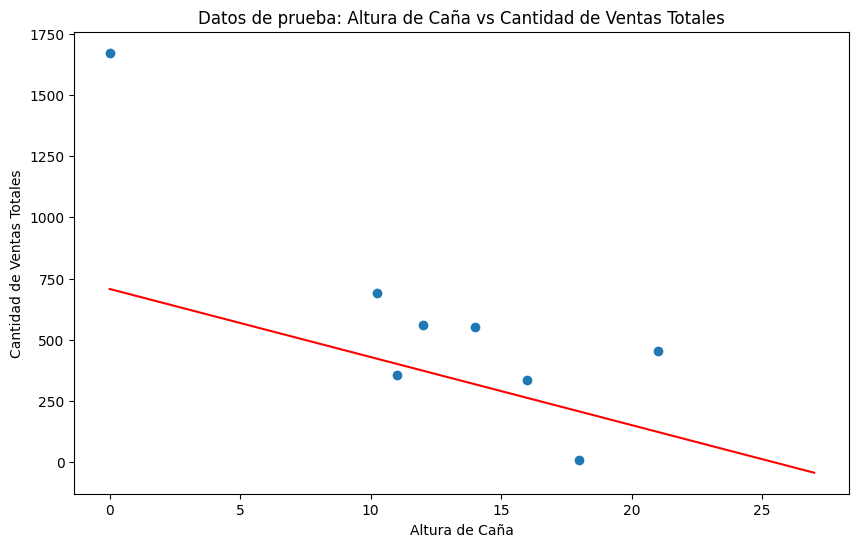

In [78]:
# Gráfico de dispersión para los datos de prueba
plt.figure(figsize=(10, 6))
plt.scatter(X_test, y_test)
plt.xlabel("Altura de Caña")
plt.ylabel("Cantidad de Ventas Totales")
plt.title("Datos de prueba: Altura de Caña vs Cantidad de Ventas Totales")

# Agregar la recta de regresión
x_line = df_grouped['Altura Caña']
y_line = slope * x_line + intercept
plt.plot(x_line, y_line, color='red')

plt.show()

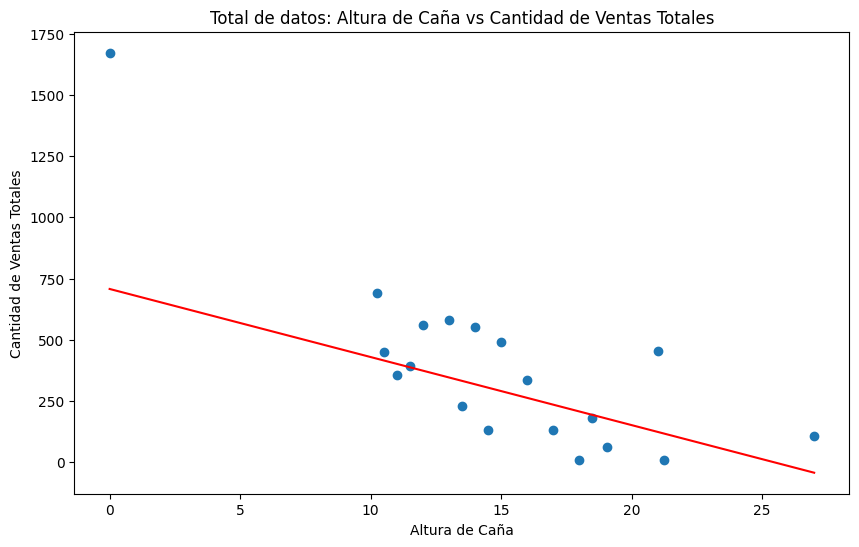

In [79]:


# Gráfico de dispersión para el total de los datos
plt.figure(figsize=(10, 6))
plt.scatter(df_grouped['Altura Caña'], df_grouped['Cantidad'])
plt.xlabel("Altura de Caña")
plt.ylabel("Cantidad de Ventas Totales")
plt.title("Total de datos: Altura de Caña vs Cantidad de Ventas Totales")

# Agregar la recta de regresión
plt.plot(x_line, y_line, color='red')

plt.show()

In [80]:
#valores estimados

y_pred = model.predict(X_test)
y_pred.round(0)

array([707., 374., 263., 422., 318., 124., 402., 207.])

In [81]:
y_test

,Cantidad
0,1672
5,561
11,334
1,691
8,552
16,455
3,355
13,8


In [84]:
# Calcular el regressor score (R²)
score = model.score(X_train, y_train)

# Imprimir el score
print("Regressor score (R²):", score)

Regressor score (R²): 0.4771118653343628


In [85]:
# Calcular el regressor score (R²)
score = model.score(X_test, y_test)

# Imprimir el score
print("Regressor score (R²):", score)

Regressor score (R²): 0.2475232310969242


In [92]:
# Input para la altura de la caña
altura_cana = float(input("Ingresa la altura de la caña: "))

# Crear un DataFrame con la altura de la caña ingresada
input_df = pd.DataFrame({'Altura Caña': [altura_cana]})

# Hacer la predicción
prediccion = model.predict(input_df)[0]

# Imprimir la predicción
print("Predicción de ventas:", prediccion)

Ingresa la altura de la caña: 5
Predicción de ventas: 568.3752960651981


In [94]:
print('Predicciones para alturas de caña de 0 a 30:')
for i in range(31):
  input_df = pd.DataFrame({'Altura Caña': [i]})
  prediccion = model.predict(input_df)[0]
  print(f'Altura de caña: {i}, Predicción de ventas: {prediccion:.1f}')

Predicciones para alturas de caña de 0 a 30:
Altura de caña: 0, Predicción de ventas: 707.3
Altura de caña: 1, Predicción de ventas: 679.5
Altura de caña: 2, Predicción de ventas: 651.7
Altura de caña: 3, Predicción de ventas: 624.0
Altura de caña: 4, Predicción de ventas: 596.2
Altura de caña: 5, Predicción de ventas: 568.4
Altura de caña: 6, Predicción de ventas: 540.6
Altura de caña: 7, Predicción de ventas: 512.8
Altura de caña: 8, Predicción de ventas: 485.0
Altura de caña: 9, Predicción de ventas: 457.2
Altura de caña: 10, Predicción de ventas: 429.4
Altura de caña: 11, Predicción de ventas: 401.6
Altura de caña: 12, Predicción de ventas: 373.8
Altura de caña: 13, Predicción de ventas: 346.0
Altura de caña: 14, Predicción de ventas: 318.3
Altura de caña: 15, Predicción de ventas: 290.5
Altura de caña: 16, Predicción de ventas: 262.7
Altura de caña: 17, Predicción de ventas: 234.9
Altura de caña: 18, Predicción de ventas: 207.1
Altura de caña: 19, Predicción de ventas: 179.3
Altur

Conclusion del modelo predictivo:
Cuanta menor altura de caña para la familia TEXANAS y subfamilia Caña media, menor cantidad de ventas. Sabiendo que se busca como objetivo realizar tareas de produccion de aproximadamente 300 pares, podriamos sugererir de fabricar zapatos con alturas de caña de 14 cm para abajo.